In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError
import torch.nn.functional as F
from torchvision.models import alexnet

# Custom collate function to filter out corrupted images
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# Custom loader to handle corrupted images
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except UnidentifiedImageError:
        print(f"Skipping corrupted image: {path}")
        return None

#defining the paths to img folders
train_dir = '/home/arnav/Documents/research_project/assignment01/images/train'
test_dir = '/home/arnav/Documents/research_project/assignment01/images/test'
val_dir = '/home/arnav/Documents/research_project/assignment01/images/val'

#Ive used .Compose to group transforms together
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor(), #Convert a PIL Image or ndarray to tensor and scale the values accordingly, this transformation scales the pixel values from the range [0, 255] to the range [0, 1].
                               transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]) #Normalize a tensor image with mean and standard deviation. Mean normalization: Subtracts the mean value from each channel (R, G, B) of the image tensor.Standard deviation normalization: Divides each channel by its standard deviation.

train_data = datasets.ImageFolder(root= train_dir, transform=transform, loader= safe_loader)
test_data = datasets.ImageFolder(root= test_dir, transform=transform, loader = safe_loader)
val_data = datasets.ImageFolder(root= val_dir, transform=transform, loader = safe_loader)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.selu(self.fc1(x))    # Use GeLU activation
        x = F.selu(self.fc2(x))    # Use GeLU activation
        x = F.selu(self.fc3(x))    # Use GeLU activation
        x = self.fc4(x)            # No activation at the output layer
        return x

class CustomAlexNet(nn.Module):
    def __init__(self):
        super(CustomAlexNet, self).__init__()
        self.alexnet = alexnet(pretrained=False)
        self.alexnet.classifier = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.SELU(),  # Use GeLU activation
            #nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.SELU(),  # Use GeLU activation
            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.alexnet(x)
        return x


In [2]:

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=25, device="cpu"):
    model.to(device)
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        
        model.train()  # Setting the model to train mode
        training_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Set gradient to zero
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)
            loss.backward()  # Backward pass
            optimizer.step()
            training_loss += loss.item()  # Loss.item() converts the loss tensor to a standard Python number (float)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(training_loss / len(train_loader))

        model.eval()  # Setting the model to validation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation during validation, which saves memory and computation time
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss: {training_loss / len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}")

    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f"Average Training Accuracy over {epochs} epochs: {avg_train_accuracy}")
    print(f"Average Validation Accuracy over {epochs} epochs: {avg_val_accuracy}")

    # Plotting accuracies and losses
    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {accuracy}")



Epoch 1: Train Loss: 0.585235364380337, Train Accuracy: 0.7142857142857143, Val Loss: 0.613429382443428, Val Accuracy: 0.6792452830188679
Epoch 2: Train Loss: 0.39578682468051, Train Accuracy: 0.8221884498480243, Val Loss: 0.6880537867546082, Val Accuracy: 0.660377358490566
Epoch 3: Train Loss: 0.3535281008198148, Train Accuracy: 0.851063829787234, Val Loss: 0.7377856075763702, Val Accuracy: 0.6226415094339622
Epoch 4: Train Loss: 0.2716604818900426, Train Accuracy: 0.8951367781155015, Val Loss: 0.6741210669279099, Val Accuracy: 0.6698113207547169
Epoch 5: Train Loss: 0.2187860728729339, Train Accuracy: 0.9209726443768997, Val Loss: 0.6177385076880455, Val Accuracy: 0.7169811320754716
Epoch 6: Train Loss: 0.17029205106553577, Train Accuracy: 0.9376899696048632, Val Loss: 0.865940660238266, Val Accuracy: 0.6226415094339622
Epoch 7: Train Loss: 0.11516589777810234, Train Accuracy: 0.9726443768996961, Val Loss: 0.9683876633644104, Val Accuracy: 0.6509433962264151
Epoch 8: Train Loss: 0.11

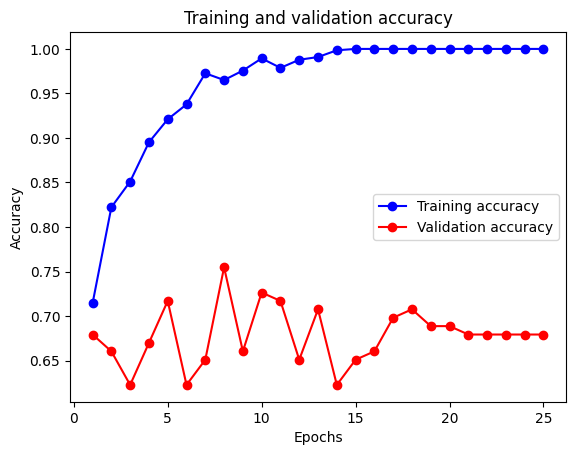

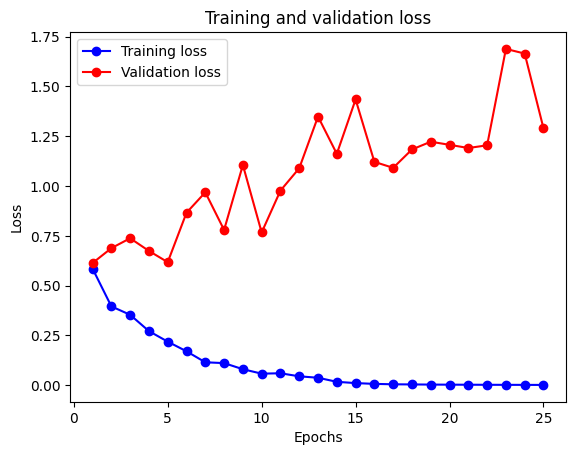

Test Loss: 1.4256333112716675, Test Accuracy: 0.7730061349693251


/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run th

Epoch 1: Train Loss: 0.6466893539542243, Train Accuracy: 0.6200607902735562, Val Loss: 0.7118342518806458, Val Accuracy: 0.6886792452830188
Epoch 2: Train Loss: 0.5173940828868321, Train Accuracy: 0.7477203647416414, Val Loss: 0.6493705660104752, Val Accuracy: 0.6415094339622641
Epoch 3: Train Loss: 0.39120863449005855, Train Accuracy: 0.8145896656534954, Val Loss: 0.46311546862125397, Val Accuracy: 0.7358490566037735
Epoch 4: Train Loss: 0.33548246536936077, Train Accuracy: 0.851063829787234, Val Loss: 0.7822471261024475, Val Accuracy: 0.6037735849056604
Epoch 5: Train Loss: 0.2661584353163129, Train Accuracy: 0.8875379939209727, Val Loss: 0.7235496789216995, Val Accuracy: 0.6792452830188679
Epoch 6: Train Loss: 0.18692664340848014, Train Accuracy: 0.925531914893617, Val Loss: 0.5824897959828377, Val Accuracy: 0.7452830188679245
Epoch 7: Train Loss: 0.13508483164367222, Train Accuracy: 0.9559270516717325, Val Loss: 0.756012924015522, Val Accuracy: 0.7358490566037735
Epoch 8: Train Los

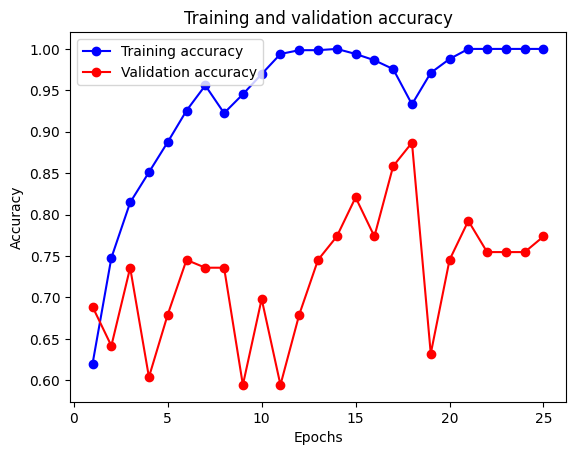

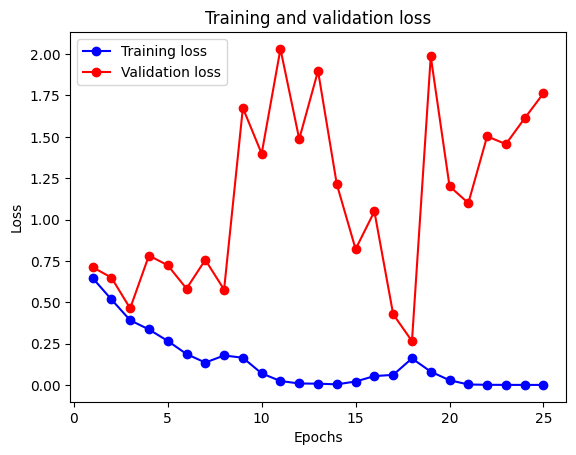

Test Loss: 1.2516431045078207, Test Accuracy: 0.7791411042944786


In [3]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)
